# Project 3: Predicting new Airbnb users' first destinations
# Part 2: SQL and EDA

## Using SQL to perform some EDA

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
from patsy import dmatrix
import datetime as dt
import numpy as np
import pickle

%matplotlib inline

from sqlalchemy import create_engine
cnx = create_engine('postgresql://emilygeller:p@54.173.47.58:5432/emilygeller')

In [2]:
pd.read_sql('select * from countries;', cnx)

,country_destination,lat_destination,lng_destination,distance_km,destination_km2,destination_language,language_levenshtein_distance
0,AU,-26.853388,133.275160,15297.7440,7741220.0,eng,0.00
1,CA,62.393303,-96.818146,2828.1333,9984670.0,eng,0.00
2,DE,51.165707,10.452764,7879.5680,357022.0,deu,72.61
3,ES,39.896027,-2.487694,7730.7240,505370.0,spa,92.25
4,FR,46.232193,2.209667,7682.9450,643801.0,fra,92.06
5,GB,54.633220,-3.432277,6883.6590,243610.0,eng,0.00
6,IT,41.873990,12.564167,8636.6310,301340.0,ita,89.40
7,NL,52.133057,5.295250,7524.3203,41543.0,nld,63.22
8,PT,39.553444,-7.839319,7355.2534,92090.0,por,95.45
9,US,36.966427,-95.844030,0.0000,9826675.0,eng,0.00


In [3]:
pd.read_sql('select * from sessions limit 5;', cnx)

,id,user_id,action,action_type,action_detail,device_type,secs_elapsed
0,0,d1mm9tcy42,lookup,None,None,Windows Desktop,319.0
1,1,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,67753.0
2,2,d1mm9tcy42,lookup,None,None,Windows Desktop,301.0
3,3,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,22141.0
4,4,d1mm9tcy42,lookup,None,None,Windows Desktop,435.0


## Constructing features from Sessions data
I'll use SQL to build them.

### Total sessions per user

In [145]:
q = '''
select user_id, count(1)
from sessions
group by user_id
limit 5;'''

In [146]:
pd.read_sql(q,cnx)

,user_id,count
0,00023iyk9l,40
1,0010k6l0om,63
2,001wyh0pz8,90
3,0028jgx1x1,31
4,002qnbzfs5,789


In [31]:
q = '''
select user_id, count(1)
from sessions
group by user_id
;'''

In [32]:
total_sessions = pd.read_sql(q,cnx)

### Total sessions per user per device

In [33]:
q = '''
select device_type, count(1)
from sessions
group by device_type;'''

In [253]:
pd.read_sql(q,cnx)

,device_type,count
0,Android Phone,835991
1,Android App Unknown Phone/Tablet,272820
2,Tablet,139859
3,iPodtouch,8186
4,iPhone,2096749
5,Blackberry,979
6,Linux Desktop,27968
7,iPad Tablet,681836
8,Windows Desktop,2648521
9,-unknown-,210059


In [34]:
q = '''
select sessions.user_id, sessions.total as Mac
from (
    select user_id, device_type, count(1) total
    from sessions
    where device_type = 'Mac Desktop'
    group by user_id, device_type) sessions

    ;'''

In [35]:
sessions_per_device = pd.read_sql(q,cnx)

In [36]:
q = '''
select sessions.user_id, sessions.total as Windows
from (
    select user_id, device_type, count(1) total
    from sessions
    where device_type = 'Windows Desktop'
    group by user_id, device_type) sessions

    ;'''

In [37]:
sessions_per_device = sessions_per_device.merge(pd.read_sql(q,cnx), on = 'user_id', how = 'outer')

In [38]:
q = '''
select sessions.user_id, sessions.total as iPhone
from (
    select user_id, device_type, count(1) total
    from sessions
    where device_type = 'iPhone'
    group by user_id, device_type
    ) sessions

    ;'''

In [39]:
sessions_per_device = sessions_per_device.merge(pd.read_sql(q,cnx), on = 'user_id', how = 'outer')

In [40]:
q = '''
select sessions.user_id, sessions.total as Android
from (
    select user_id, device_type, count(1) total
    from sessions
    where device_type = 'Android Phone'
    group by user_id, device_type
    ) sessions

    ;'''

In [41]:
sessions_per_device = sessions_per_device.merge(pd.read_sql(q,cnx), on = 'user_id', how = 'outer')

In [42]:
sessions_per_device = sessions_per_device.fillna(0)

In [43]:
sessions_per_device.describe()

,mac,windows,iphone,android
count,121605.000000,121605.000000,121605.000000,121605.000000
mean,29.487982,21.779705,17.242293,6.874643
std,76.538652,64.024620,61.098359,45.417618
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000
75%,24.000000,11.000000,4.000000,0.000000
max,2705.000000,2335.000000,2473.000000,2264.000000


In [44]:
sessions_per_device.columns = ['id','total_sessions_on_mac','total_sessions_on_windows','total_sessions_on_iphone','total_sessions_on_android']

###  Total seconds on site per user
(Not included in final model)

In [160]:
q = '''
select user_id, sum(secs_elapsed)
from sessions
group by user_id
limit 5;
'''

In [161]:
pd.read_sql(q,cnx)

,user_id,sum
0,00023iyk9l,867896.0
1,0010k6l0om,586543.0
2,001wyh0pz8,282965.0
3,0028jgx1x1,297010.0
4,002qnbzfs5,6487080.0


### Total seconds on site per user per device
(Not included in final model)

In [10]:
q = '''
select device_type, count(user_id)
from sessions
group by device_type
order by count desc;'''

In [11]:
pd.read_sql(q,cnx)

,device_type,count
0,Mac Desktop,3585886
1,Windows Desktop,2648521
2,iPhone,2096749
3,Android Phone,835991
4,iPad Tablet,681836
5,Android App Unknown Phone/Tablet,272820
6,-unknown-,210059
7,Tablet,139859
8,Linux Desktop,27968
9,Chromebook,22272


Let's only look at the total time per user for the top four devices: `Mac Desktop`, `Windows Desktop`, `iPhone`, `Android Phone`.

In [263]:
q = '''
select sessions.user_id, sessions.total as Mac
from (
    select user_id, device_type, sum(secs_elapsed) total
    from sessions
    where device_type = 'Mac Desktop'
    group by user_id, device_type
    limit 5) sessions

    ;'''

In [264]:
pd.read_sql(q,cnx)

,user_id,mac
0,00023iyk9l,295642.0
1,0010k6l0om,586543.0
2,0035hobuyj,5724670.0
3,00378ocvlh,1827164.0
4,0063bawn05,2978016.0


Verification:

In [31]:
q = '''
select user_id, device_type, sum(secs_elapsed)
from sessions
where user_id in ('0010k6l0om', '0035hobuyj', '00023iyk9l')
group by user_id, device_type;'''

In [32]:
pd.read_sql(q,cnx)

,user_id,device_type,sum
0,00023iyk9l,iPhone,572254.0
1,0010k6l0om,Mac Desktop,586543.0
2,00023iyk9l,Mac Desktop,295642.0
3,0035hobuyj,Mac Desktop,5724670.0


## Feature Engineering

In [3]:
sessions = pd.read_csv('sessions_cleaned.csv')

In [12]:
users = pd.read_csv('users_cleaned.csv')

In [13]:
users.head()

,Unnamed: 0,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,2,4ft3gnwmtx,2010-09-28 00:00:00,2009-06-09 23:12:47,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
1,3,bjjt8pjhuk,2011-12-05 00:00:00,2009-10-31 06:01:29,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
2,4,87mebub9p4,2010-09-14 00:00:00,2009-12-08 06:11:05,2010-02-18,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US
3,5,osr2jwljor,2010-01-01 00:00:00,2010-01-01 21:56:19,2010-01-02,-unknown-,NaN,basic,0,en,other,other,omg,Web,Mac Desktop,Chrome,US
4,6,lsw9q7uk0j,2010-01-02 00:00:00,2010-01-02 01:25:58,2010-01-05,FEMALE,46.0,basic,0,en,other,craigslist,untracked,Web,Mac Desktop,Safari,US


In [14]:
users.first_affiliate_tracked.value_counts()

untracked        47739
linked           20102
omg              16425
tracked-other     2290
product            542
marketing           63
local ops            9
Name: first_affiliate_tracked, dtype: int64

In [15]:
users['date_account_created'] = pd.to_datetime(users['date_account_created'], infer_datetime_format = True)
users['timestamp_first_active'] = pd.to_datetime(users['timestamp_first_active'], format = '%Y-%m-%d %H:%M:%S')
users['date_first_booking'] = pd.to_datetime(users['date_first_booking'],format = '%Y-%m-%d')

In [16]:
users['signup_flow'] = (users.signup_flow ==3)*1

In [17]:
users['affiliate_channel'] = (users.affiliate_channel == 'direct')*1

In [18]:
users['affiliate_provider'] = (users.affiliate_provider == 'direct')*1

In [19]:
users['first_affiliate_tracked'] = (users.first_affiliate_tracked == 'untracked')*1

In [20]:
#users_dummied = pd.get_dummies(users[['gender','signup_method','signup_app','first_device_type','first_browser','affiliate_channel','affiliate_provider','first_affiliate_tracked']],drop_first = True)
users_dummied = pd.get_dummies(users[['gender','signup_method','signup_app']],drop_first = True)

In [21]:
users_dummied['langues_en'] = pd.get_dummies(users['language']).loc[:,'en']

Find the length of time between the account being created and the user being first active.

Positive -> user was active before they made their account

-1 -> First time the user was active was when they made their account

In [22]:
users_dummied['diff_account_to_first_active'] = (users['date_account_created']-users['timestamp_first_active']).dt.days
users_dummied['diff_account_to_first_booking'] = (users['date_first_booking']-users['date_account_created']).dt.days

In [23]:
users_dummied

,gender_FEMALE,gender_MALE,gender_OTHER,signup_method_facebook,signup_method_google,signup_app_Moweb,signup_app_Web,signup_app_iOS,langues_en,diff_account_to_first_active,diff_account_to_first_booking
0,1,0,0,0,0,0,1,0,1,475,-57
1,1,0,0,1,0,0,1,0,1,764,278
2,0,0,0,0,0,0,1,0,1,279,-208
3,0,0,0,0,0,0,1,0,1,-1,1
4,1,0,0,0,0,0,1,0,1,-1,3
5,1,0,0,0,0,0,1,0,1,-1,10
6,1,0,0,0,0,0,1,0,1,-1,206
7,0,0,0,0,0,0,1,0,1,-1,0
8,1,0,0,0,0,0,1,0,1,-1,2
9,0,0,0,0,0,0,1,0,1,-1,13


In [24]:
users.language.value_counts()

en    86664
zh      521
fr      399
es      275
de      270
ko      241
ru      110
it      104
ja       84
pt       62
sv       44
nl       35
tr       20
da       19
pl       13
no       13
cs        9
fi        7
el        6
hu        4
th        4
ca        2
is        2
Name: language, dtype: int64

In [25]:
users_dummied.head()

,gender_FEMALE,gender_MALE,gender_OTHER,signup_method_facebook,signup_method_google,signup_app_Moweb,signup_app_Web,signup_app_iOS,langues_en,diff_account_to_first_active,diff_account_to_first_booking
0,1,0,0,0,0,0,1,0,1,475,-57
1,1,0,0,1,0,0,1,0,1,764,278
2,0,0,0,0,0,0,1,0,1,279,-208
3,0,0,0,0,0,0,1,0,1,-1,1
4,1,0,0,0,0,0,1,0,1,-1,3


In [26]:
users_dummied['id'] = users['id']
users_dummied['age'] = users['age']

Turn Target into binary classes (domestic v international)

In [27]:
country_destinations = pd.get_dummies(users['country_destination'])
y = country_destinations['US']

In [45]:
total_sessions.columns = ['id', 'total_sessions']

In [46]:
users_dummied = pd.merge(users_dummied, total_sessions, on='id', how = 'left')


In [47]:
users_dummied = pd.merge(users_dummied,sessions_per_device, on='id', how = 'left')

In [48]:
users_dummied[['total_sessions','total_sessions_on_mac','total_sessions_on_windows','total_sessions_on_iphone','total_sessions_on_android']] = users_dummied[['total_sessions','total_sessions_on_mac','total_sessions_on_windows','total_sessions_on_iphone','total_sessions_on_android']].fillna(0)


In [49]:
users_dummied.diff_account_to_first_active = users_dummied.diff_account_to_first_active.replace(-1,0)

In [50]:
users = users_dummied.join(y)

In [51]:
users['no_age_entered'] = users.age.isnull()*1

In [52]:
users.age = users.age.fillna(users.age.mean())

In [53]:
users.total_sessions_on_android.describe()

count    88908.000000
mean         0.704155
std         19.119412
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max       2264.000000
Name: total_sessions_on_android, dtype: float64

In [54]:
with open('users.pkl', 'wb') as picklefile: # wb: write, binary
    pickle.dump(users, picklefile) #dump data into pickle file

In [182]:
users.columns

Index(['gender_FEMALE', 'gender_MALE', 'gender_OTHER',
       'signup_method_facebook', 'signup_method_google', 'signup_app_Moweb',
       'signup_app_Web', 'signup_app_iOS', 'first_device_type_Android Tablet',
       'first_device_type_Desktop (Other)', 'first_device_type_Mac Desktop',
       'first_device_type_Other/Unknown',
       'first_device_type_SmartPhone (Other)',
       'first_device_type_Windows Desktop', 'first_device_type_iPad',
       'first_device_type_iPhone', 'first_browser_AOL Explorer',
       'first_browser_Android Browser', 'first_browser_Apple Mail',
       'first_browser_Avant Browser', 'first_browser_BlackBerry Browser',
       'first_browser_Camino', 'first_browser_Chrome',
       'first_browser_Chrome Mobile', 'first_browser_Chromium',
       'first_browser_CometBird', 'first_browser_CoolNovo',
       'first_browser_Firefox', 'first_browser_Googlebot', 'first_browser_IE',
       'first_browser_IE Mobile', 'first_browser_IceWeasel',
       'first_browser_Iron'

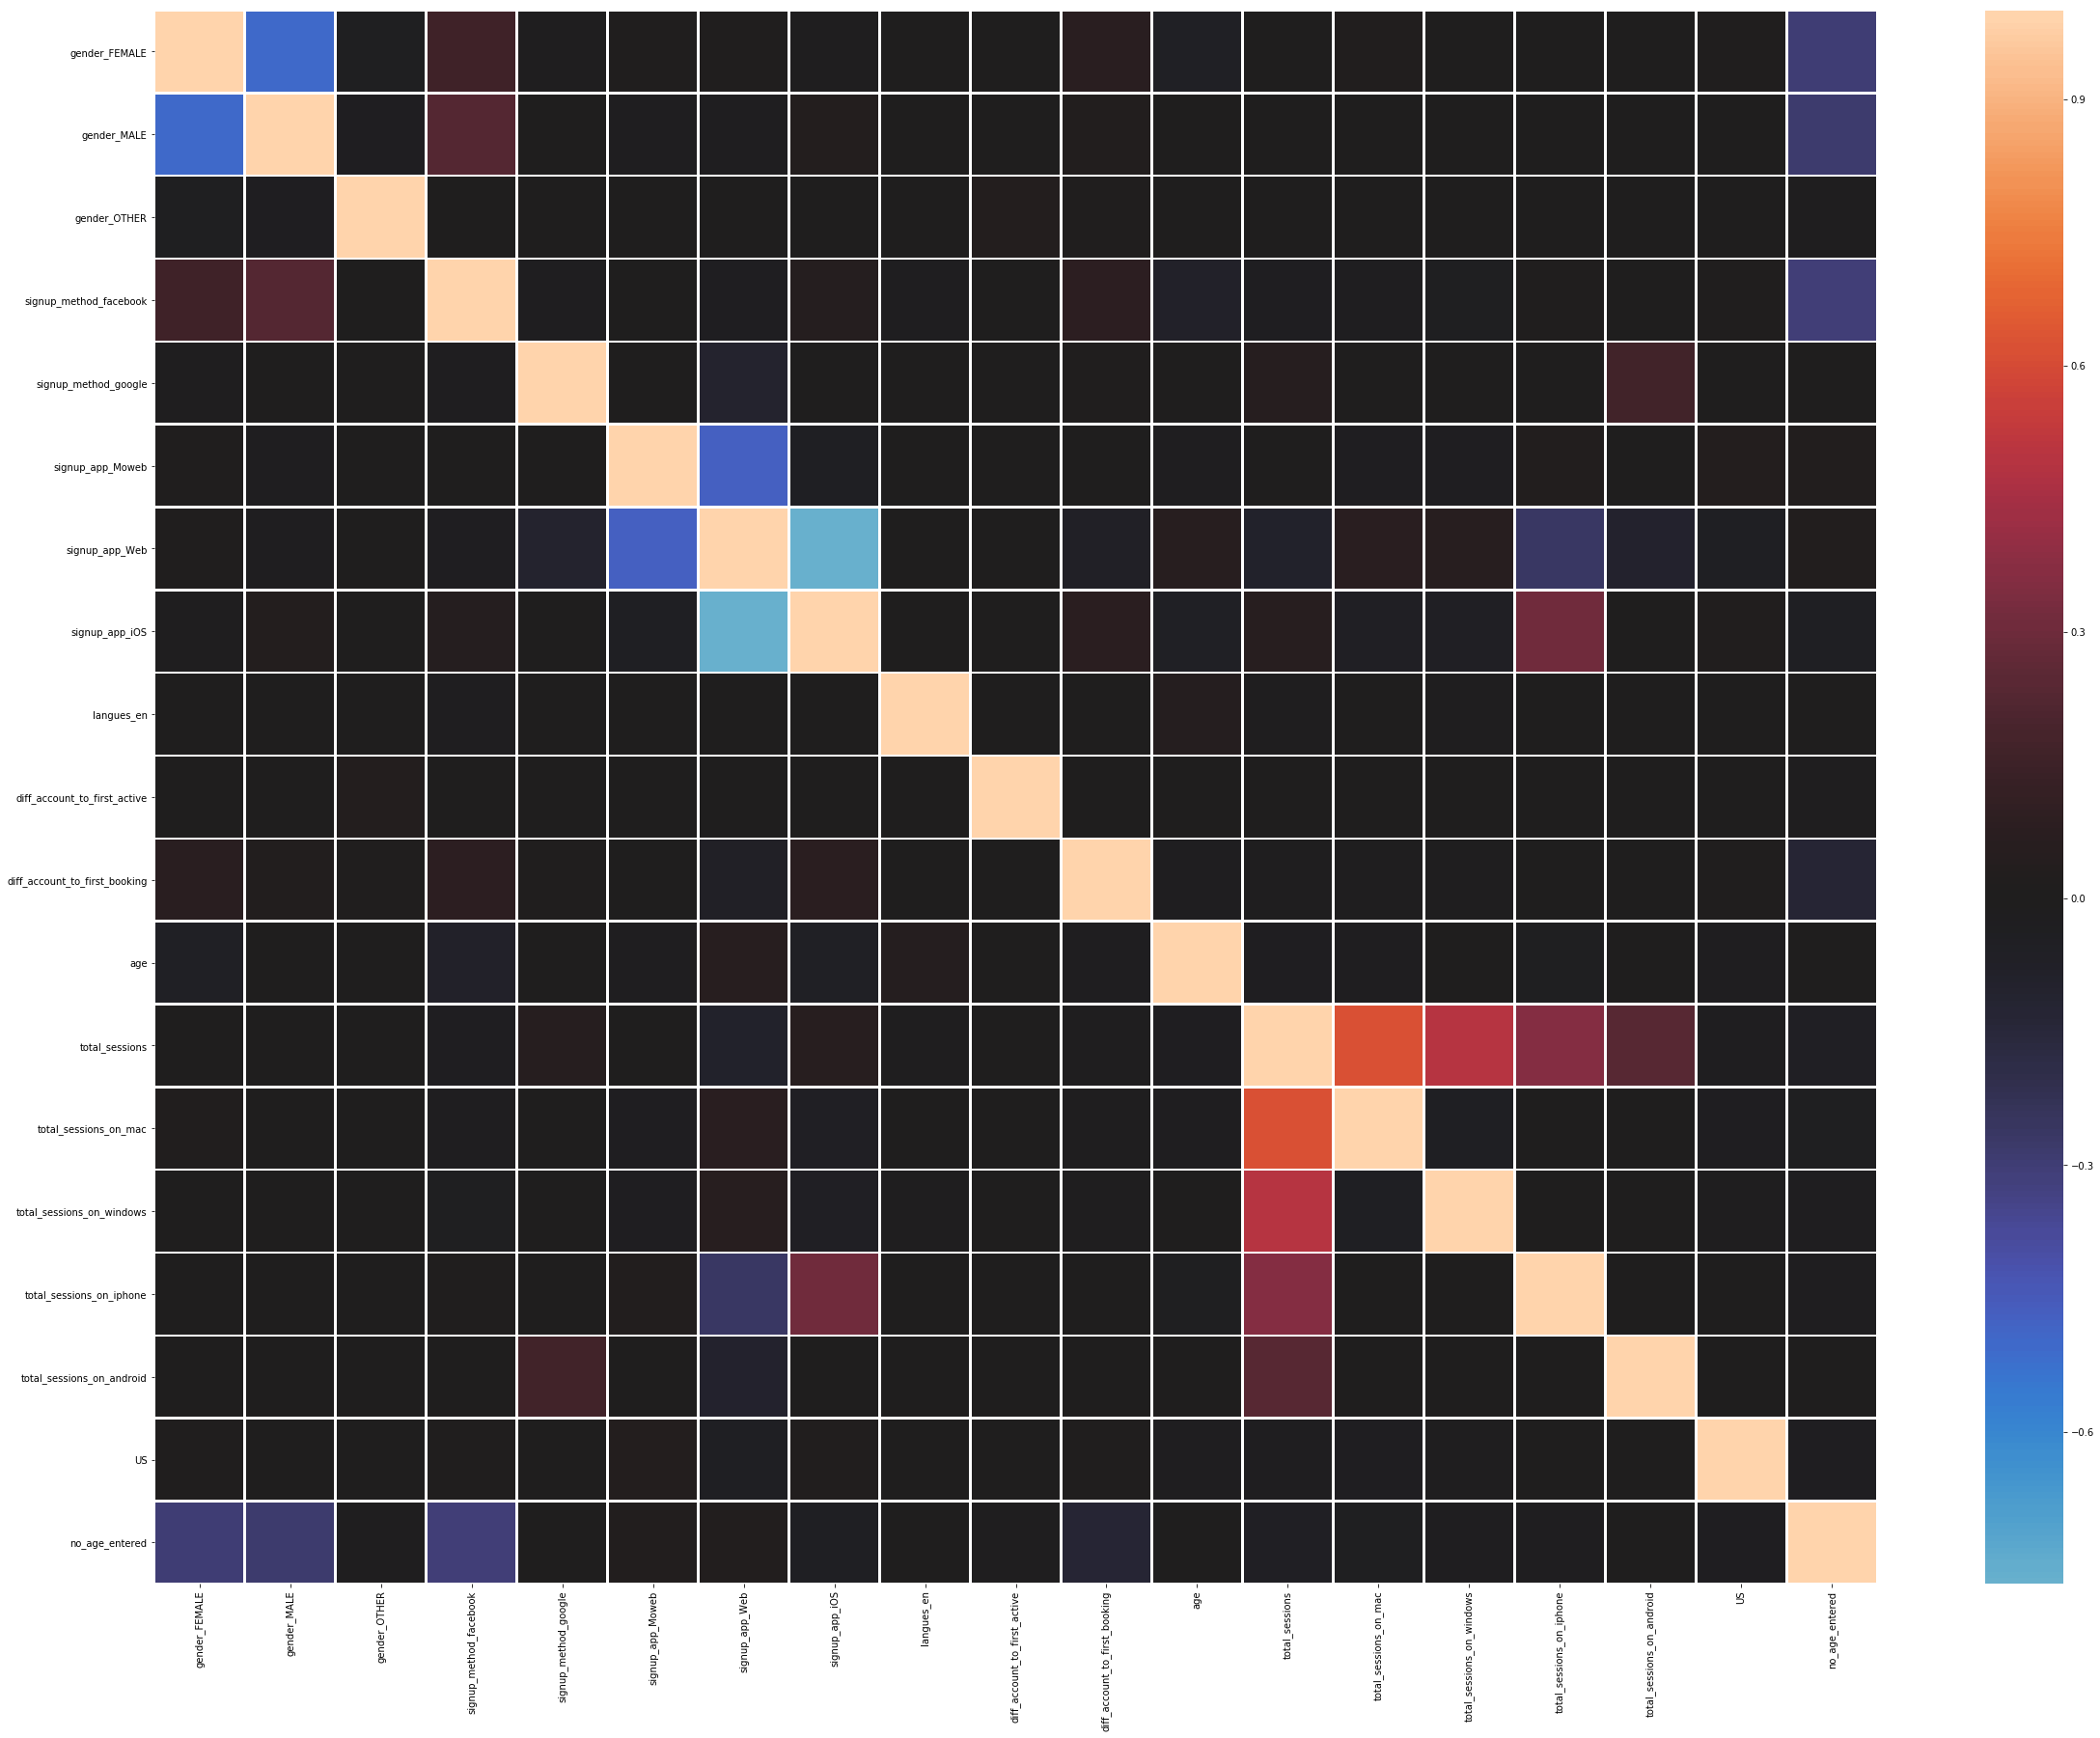

In [56]:
import seaborn as sns
plt.figure(figsize = (40,30))
ax = sns.heatmap(users.corr(),  linewidths=1.5, center = 0)

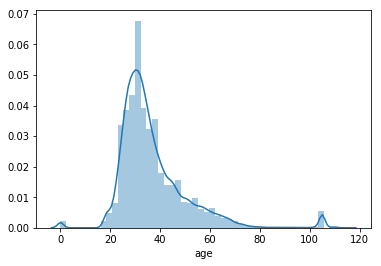

In [66]:
sns.distplot(users.age.dropna())

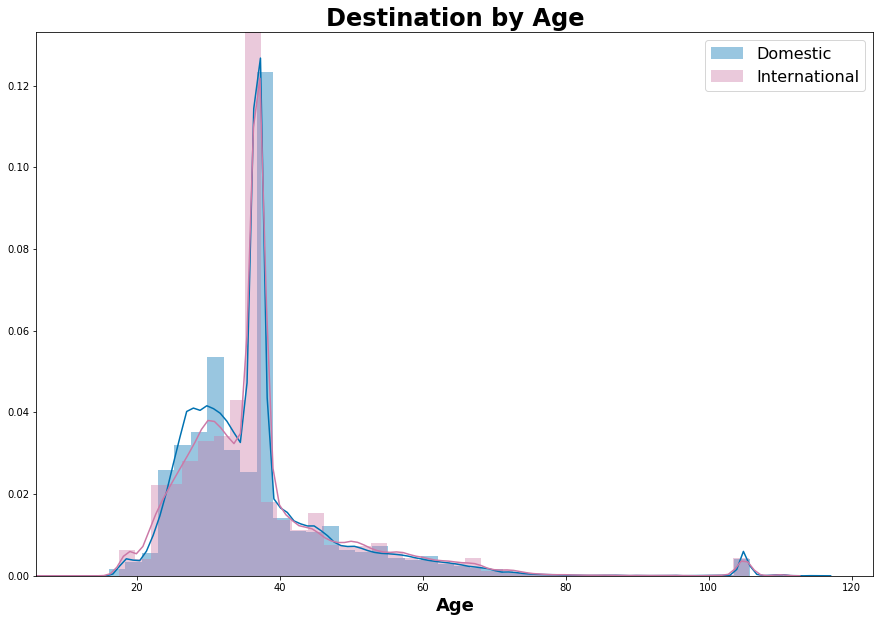

In [68]:
f, ax = plt.subplots(1,1,figsize = (15,10))

#sns.set_palette(sns.color_palette('colorblind'))
sns.distplot(users[users.US == 1].age.dropna(),color = sns.color_palette('colorblind')[0], label = 'Domestic')
sns.distplot(users[users.US == 0].age.dropna(),color = sns.color_palette('colorblind')[3], label = 'International')
plt.xlim(xmin = 6)
plt.xlabel('Age',fontweight = 'bold', fontsize = 18)
ax.legend(fontsize = 16)
plt.title('Destination by Age', fontweight = 'bold', fontsize = 24);
plt.savefig('Destinationbyage',bbox_inches='tight')

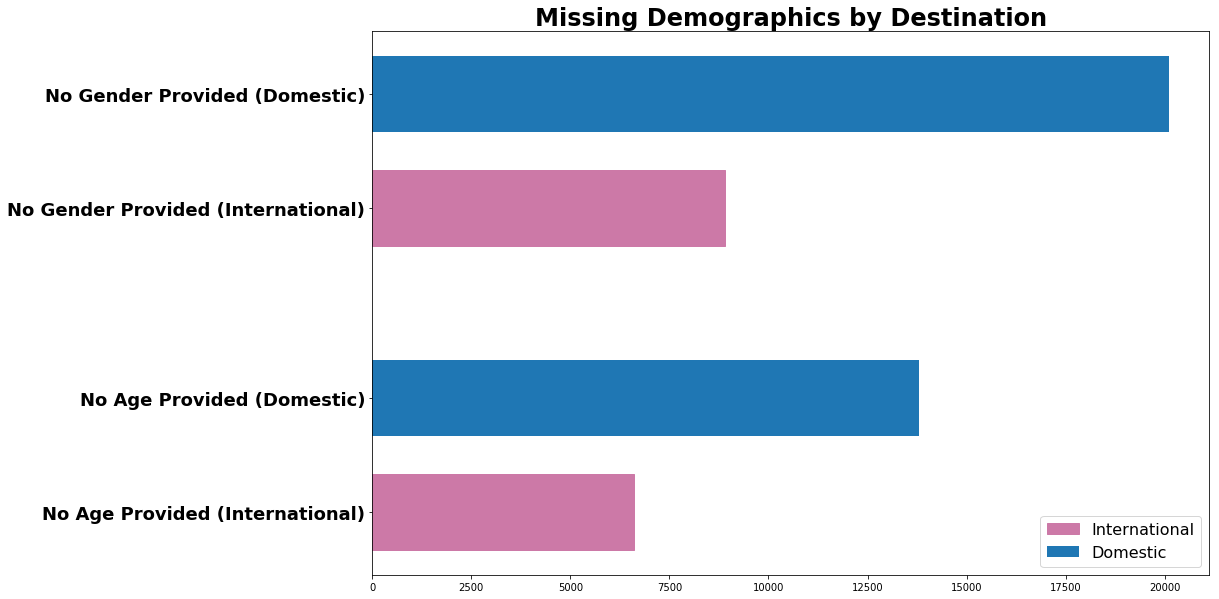

''

In [72]:
from numpy import arange
pos = [0.4,0.55, 0.8,0.95]
f, ax = plt.subplots(1,1,figsize = (15,10))
barlist = ax.barh(pos,
        [
         users[users.no_age_entered == 1].US.value_counts()[0],
         users[users.no_age_entered == 1].US.value_counts()[1],
         users[(users.gender_FEMALE + users.gender_MALE + users.gender_OTHER) == 0 ].US.value_counts()[0], 
         users[(users.gender_FEMALE + users.gender_MALE + users.gender_OTHER) == 0 ].US.value_counts()[1]] 
        ,height = 0.1)


barlist[0].set_color(sns.color_palette('colorblind')[3])
barlist[2].set_color(sns.color_palette('colorblind')[3])

plt.yticks(pos,
           (
            'No Age Provided (International)', 
            'No Age Provided (Domestic)',
            'No Gender Provided (International)',
            'No Gender Provided (Domestic)'
           ), fontweight = 'bold', fontsize = 18)
plt.legend((barlist[0], barlist[1]), ('International','Domestic'), fontsize = 16)
plt.title('Missing Demographics by Destination', fontweight = 'bold', fontsize = 24)
plt.savefig('missingdemographics',bbox_inches='tight')
plt.show()
;

In [232]:
users[(users.gender_FEMALE + users.gender_MALE + users.gender_OTHER) == 0 ].US.value_counts()[0]

8909

In [132]:
users = pd.read_csv('users_cleaned.csv')

In [135]:
users.country_destination.value_counts()

US       62376
other    10094
FR        5023
IT        2835
GB        2324
ES        2249
CA        1428
DE        1061
NL         762
AU         539
PT         217
Name: country_destination, dtype: int64

In [136]:
country_destinations = pd.get_dummies(users['country_destination'])
y = country_destinations['US']

In [137]:
users = users.join(y)

In [144]:
users[users.US == 1].gender.value_counts()

FEMALE       22694
-unknown-    20109
MALE         19457
OTHER          116
Name: gender, dtype: int64

In [145]:
users.head()

,Unnamed: 0,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination,US
0,2,4ft3gnwmtx,2010-09-28 00:00:00,2009-06-09 23:12:47,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US,1
1,3,bjjt8pjhuk,2011-12-05 00:00:00,2009-10-31 06:01:29,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other,0
2,4,87mebub9p4,2010-09-14 00:00:00,2009-12-08 06:11:05,2010-02-18,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US,1
3,5,osr2jwljor,2010-01-01 00:00:00,2010-01-01 21:56:19,2010-01-02,-unknown-,NaN,basic,0,en,other,other,omg,Web,Mac Desktop,Chrome,US,1
4,6,lsw9q7uk0j,2010-01-02 00:00:00,2010-01-02 01:25:58,2010-01-05,FEMALE,46.0,basic,0,en,other,craigslist,untracked,Web,Mac Desktop,Safari,US,1
